# Notebook 06:

Is it possible to predict kt as good as
ava_rad got predicted in the previous notebook?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

import pickle

from utility.model_evaluation import evaluate_data
from utility.model_evaluation import evaluate_cities

C:\Users\merto\AppData\Local\Temp\ipykernel_3596\311900035.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
with open(r'..\data\interim\05_machine_learning\not_cloudy_data.pkl', 'rb') as f:
    data = pickle.load(f)

In [3]:
data.head()

,time,year,month,dom,doy,doysin,city,temp,rel_hum,abs_hum,ava_rad,et_rad,kt
0,1993-01-01,1993.0,1.0,1.0,1.0,0.009,BND,19.11,0.782,12.748946,12.62,21.652331,0.582847
1,1993-01-01,1993.0,1.0,1.0,1.0,0.009,ESF,0.44,0.462,2.240238,12.90,18.352701,0.702894
3,1993-01-01,1993.0,1.0,1.0,1.0,0.009,KRM,4.83,0.576,3.915072,13.38,19.798337,0.675814
4,1993-01-01,1993.0,1.0,1.0,1.0,0.009,MSH,-0.06,0.732,3.549468,10.42,16.104011,0.647044
5,1993-01-01,1993.0,1.0,1.0,1.0,0.009,SHZ,4.61,0.602,4.091794,14.62,20.216349,0.723177


## Predicting kt using random forest:

In [4]:
model = RandomForestRegressor()
evaluate_data(model, data, output_column='kt')
pass

Mean R2 score    [train : 0.896, test : 0.264]
Mean rmse        [train : 0.040, test : 0.107]


Although we predicted ava_rad with good scores, the results of predicting kt are too bad!
It's good to check if training models on individual cities will increase scores or not.

In [5]:
cities = data.city.unique()
r2s, rmses, models = evaluate_cities(model, data, output_column='kt')

Average R2 score                [train : 0.887, test : 0.198]
Average root mean squared error [train : 0.038, test : 0.101]


In [6]:
r2s.describe()

,train,test
count,25.000000,25.000000
mean,0.887259,0.197641
std,0.010975,0.074755
min,0.871018,0.048670
25%,0.880270,0.173750
50%,0.888980,0.211116
75%,0.892840,0.232693
max,0.916160,0.359861


Even training different models on each city doesn't result good scores.

The highest r2 between cities is only 0.36. It's not good!

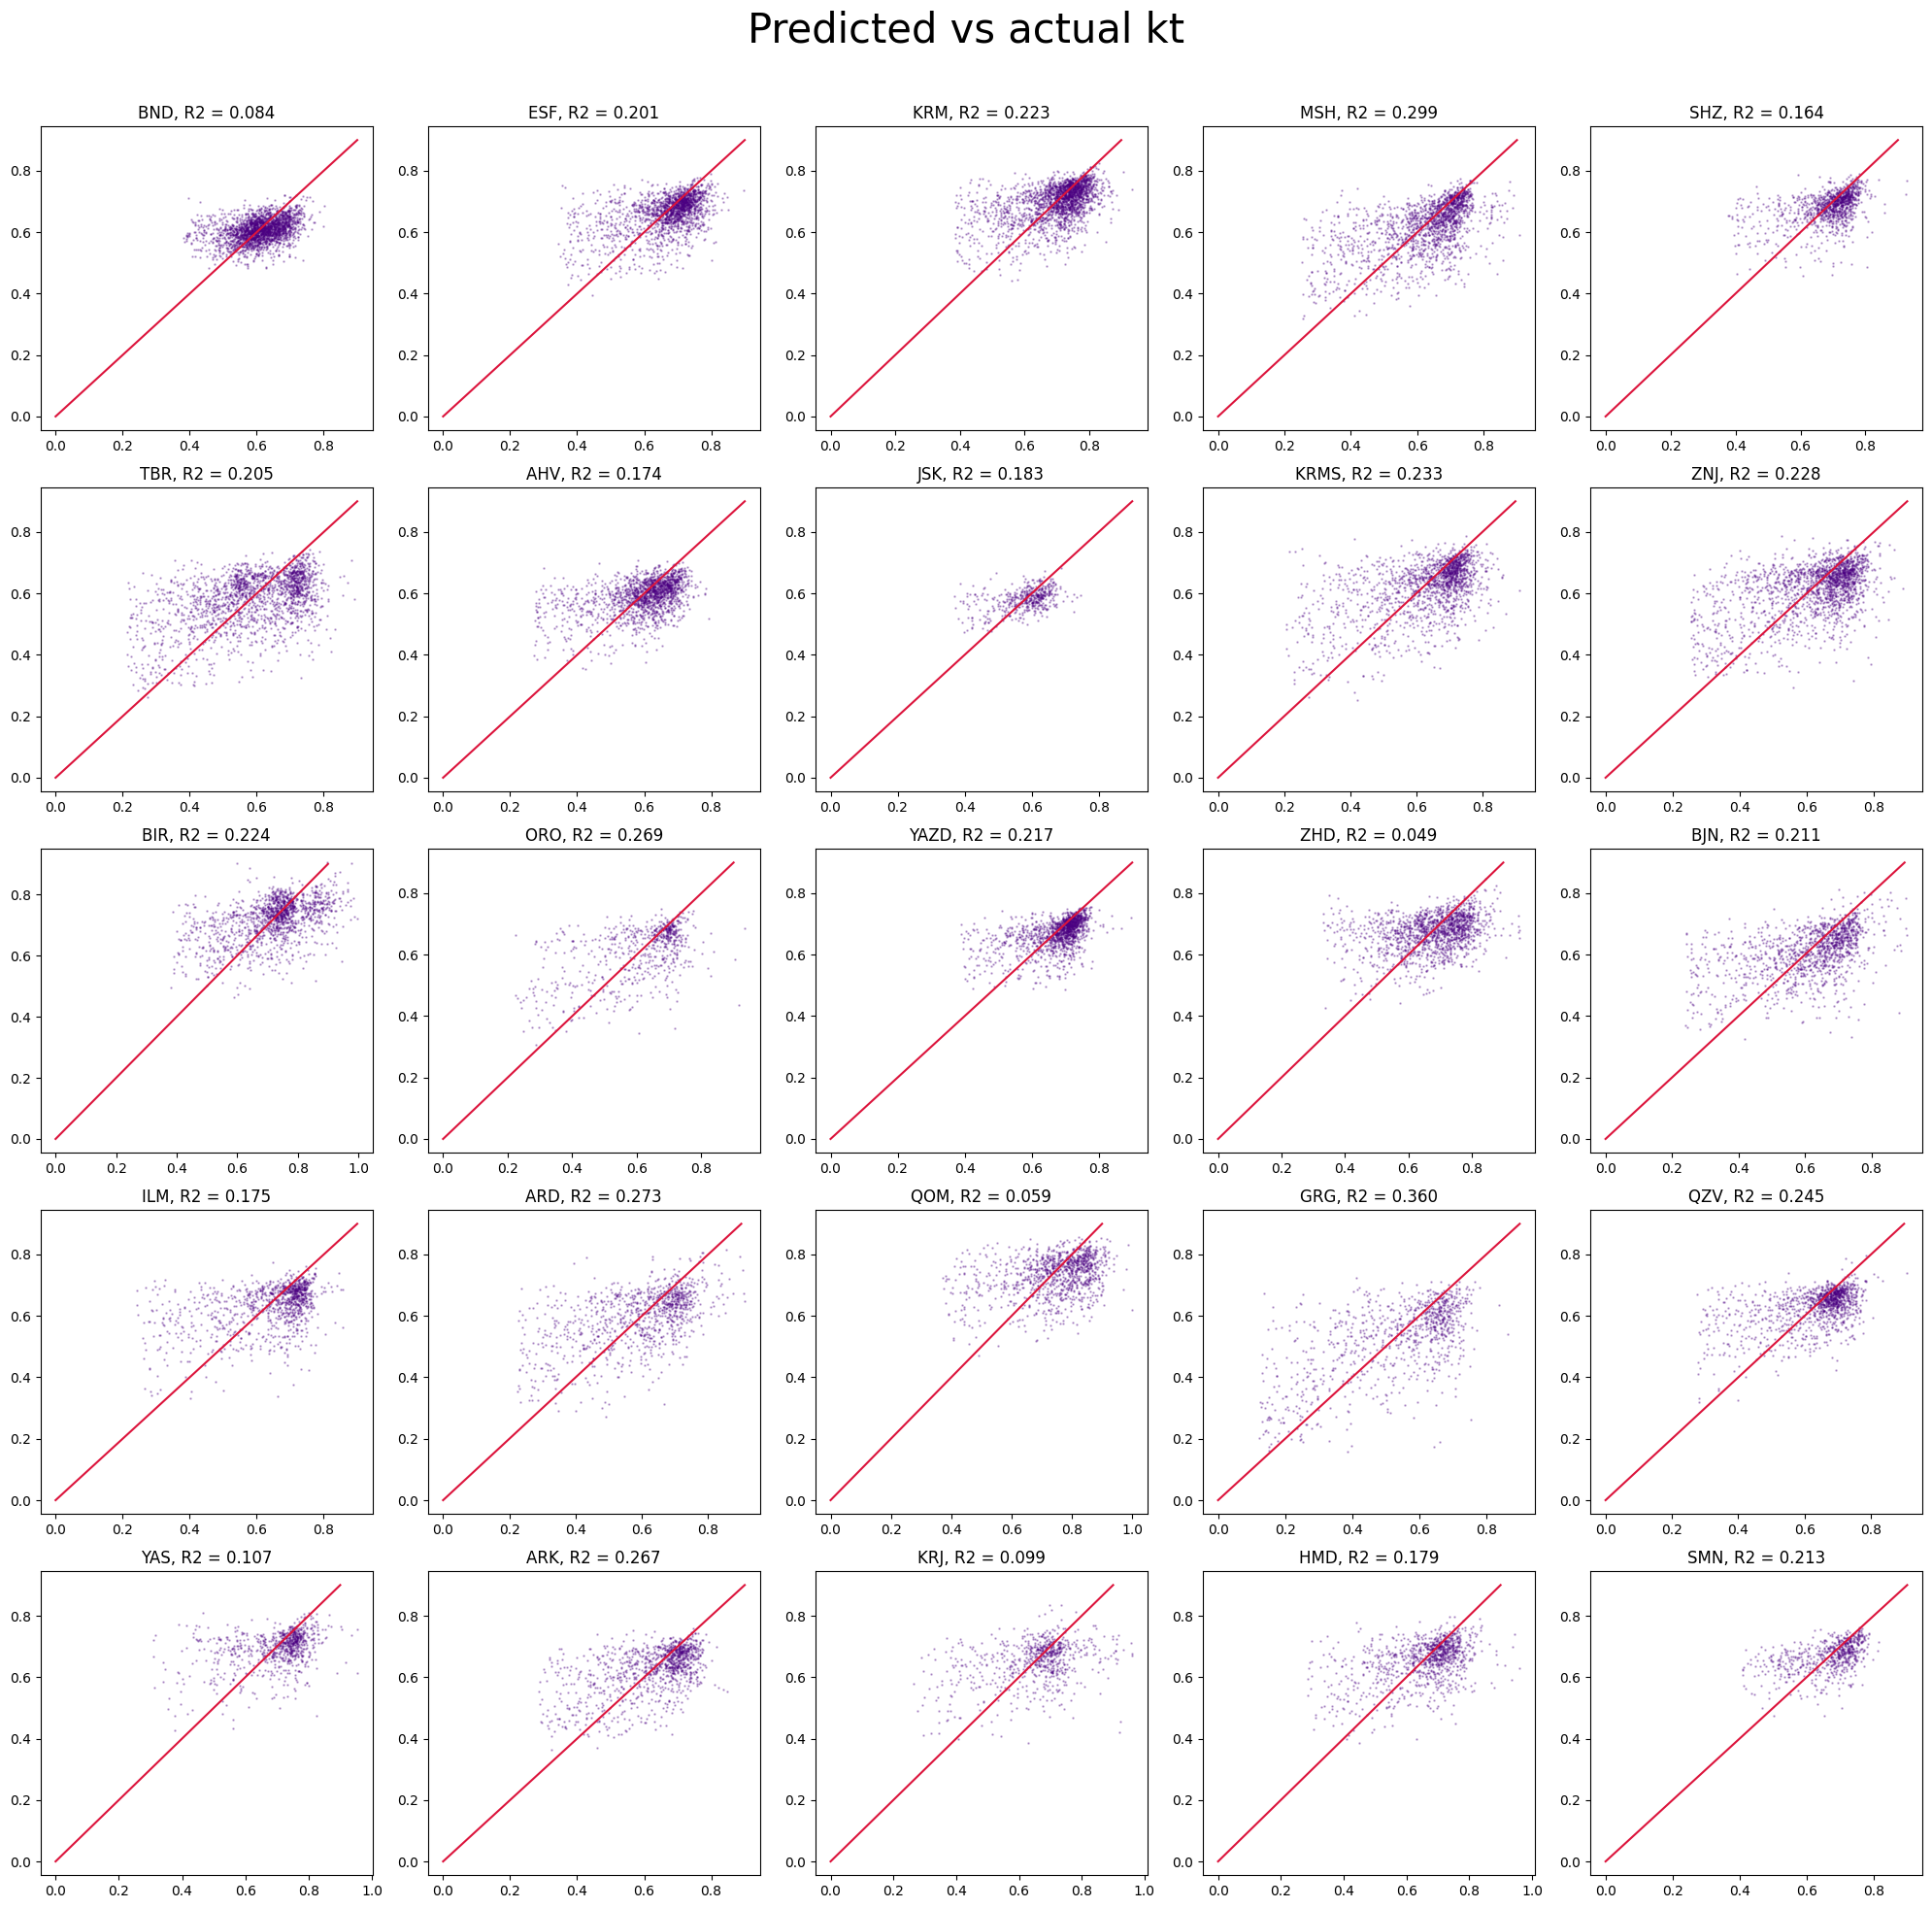

In [7]:
# Ploting predicted and actual values of kt for each city:

fig, axes = plt.subplots(5, 5, figsize=(20, 20))

for city, ax in zip(cities, axes.ravel()):
    city_data = data[data.city == city]
    X = city_data[['doysin', 'temp', 'rel_hum', 'abs_hum', 'et_rad']]
    y = city_data['kt']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

    y_pred = models[city].predict(X_test)
    ax.scatter(y_test, y_pred, s=0.7, alpha=0.3, c='indigo')

    line = [i/10 for i in range(10)]
    ax.plot(line, line, c='crimson')

    r2 = r2s.test[city]
    ax.set_title('{}, R2 = {:.3f}'.format(city, r2))

fig.suptitle('Predicted vs actual kt', fontsize=30)
fig.tight_layout()
fig.subplots_adjust(top=0.92)

## What's the problem?

We trained a model with only feature of et_rad for predicting ava_rad in notebook 05,

and we got r2 score of 0.75.

And also we got r2 score of 0.26 for a model that was trying to predict kt!

So what's going on?

the problem is that previously our model was not predicting ava_rad directly!

The model was predicting et_rad, and sending a fraction of et_rad to the output as ava_rad!

And the feature importance values of the model can describe this phenomenon.

So we are not able to predict what fraction of et_rad will reach the ground! :(

But to become more confident about this hypothesis, we just do another test.

Lets multiply et_values of each city, by the average kt of each city.

And see if the results can describe ava_rad or not!

In [8]:
r2_scores = {}

for city in cities:
    city_data = data[data.city == city]
    kt_mean = city_data.kt.mean()
    r2_scores[city] = r2_score(city_data.ava_rad, city_data.et_rad * kt_mean)

r2_scores = pd.Series(r2_scores)
r2_scores = pd.DataFrame(r2_scores, columns=['r2'])

In [9]:
r2_scores

,r2
BND,0.748914
ESF,0.801030
KRM,0.767997
MSH,0.751879
SHZ,0.788490
TBR,0.712470
AHV,0.760901
JSK,0.724662
KRMS,0.695391
ZNJ,0.716223


Most of scores are high.

Above results proved our hypothesis!

## Checking the models that was trained to predict kt:

Although the models were not good, we are going to investigate them.

Maybe we find some clues.

Let's check feature importance:

In [10]:
feature_importances = {}

for city in cities:
    model = models[city]
    feature_imp = model.feature_importances_
    feature_importances[city] = feature_imp

#feature_importances = pd.Series(feature_importances)
feature_importances = pd.DataFrame(feature_importances).T
feature_importances.columns = (model.feature_names_in_)
feature_importances.describe()

,doysin,temp,rel_hum,abs_hum,et_rad
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.134463,0.172974,0.307259,0.239787,0.145516
std,0.013193,0.023457,0.082522,0.052970,0.015367
min,0.113530,0.112881,0.176003,0.131020,0.115565
25%,0.126049,0.164557,0.246509,0.217471,0.137737
50%,0.132243,0.173960,0.304593,0.243829,0.143594
75%,0.141004,0.184176,0.347694,0.262556,0.153453
max,0.163693,0.229282,0.499963,0.349415,0.177182


Feature importances show that humidity is the most significant one.

Lets see how a model preform without having humidity:

In [11]:
model = RandomForestRegressor()
evaluate_data(model, data, input_columns = ['doysin', 'temp', 'et_rad'], output_column = 'kt')
pass

Mean R2 score    [train : 0.852, test : 0.041]
Mean rmse        [train : 0.048, test : 0.122]


R2 score of model has droped significantly. humidity was the most important feature truly.

## Final words:

Although we thought that we was able to predict the effect of different features on ava_rad.

In this notebook we reveald that it's not possible. It's only possible to predict et_rad.

As et_rad and ava_rad have same patterns, we mistakenly thought that we was predicting ava_rad.

## Conclusion:
In this notebook:

1. kt is predicted
2. The reason of models poor performane is investigated
3. Importance of different features for predicting kt is investigated.